In [1]:
import pygame, sys, random
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
input_size = 22
output_size = 8
hidden_size = 10
learning_rate = 0.1

X = tf.placeholder(tf.float32,  [None, input_size], name = "input_x")
W1 = tf.get_variable("W1", shape = [input_size, hidden_size], initializer = tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.tanh(tf.matmul(X, W1))
W2 = tf.get_variable("W2", shape = [hidden_size, output_size], initializer = tf.contrib.layers.xavier_initializer())

Qpred = tf.matmul(layer1, W2)

Y = tf.placeholder(shape  = [None, output_size], dtype = tf.float32)

loss = tf.reduce_sum(tf.square(Y-Qpred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < 400):
        xPos = 400
        flagWall = -1
    elif(xPos > 880):
        xPos = 880
        flagWall = -1
    if(yPos > 690):
        yPos = 690
        flagWall = -1
    elif(yPos < 210):
        yPos = 210
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [4]:
def stateGenerator(obsPosition, agtPosition, wallcheck):
    returnSum = []
    for i in range(0,10):
        #returnSum = returnSum + [math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2)]
        returnSum = returnSum + [agtPosition[0] - obsPosition[i][0], agtPosition[1] - obsPosition[i][1]]
    returnSum = returnSum + [agtPosition[0] - 640, agtPosition[1] - 450]
    return returnSum

In [5]:
#display
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

num_episodes = 10000
dis = 0.9
rList = []

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for episodes in range(num_episodes):
        
        x = 400
        y = 690
        obstaclePos = [[0, 0] for _ in range(10)]
        for i in range(0,1):
            while True:
                obstaclePos[i][0] = 400 + random.randrange(1,490)
                obstaclePos[i][1] = 690 - random.randrange(1,490)
                if obstaclePos[i][0] <= 620 or obstaclePos[i][0] >= 660:
                    if obstaclePos[i][1] >= 470 or obstaclePos[i][1] <= 430:
                        break

        s = stateGenerator(obstaclePos, [x,y], -1)
        #e = 1. / ((episodes/10) + 1)
        e = 0.1
        rAll = 0
        step_count = 0
        ObjectIndex = -1
        while True:
            step_count += 1
            Qinput = np.reshape(s, [1, input_size])
            Qs = sess.run(Qpred, feed_dict = {X: Qinput})
            
            if np.random.rand(1) < e:
                a = random.randrange(0,8)
            else:
                a = np.argmax(Qs)
            
            xMove = 0
            yMove = 0
            if a == 0:
                xMove = 1
            elif a == 1:
                xMove = 1
                yMove = 1
            elif a == 2:
                yMove = 1
            elif a == 3:
                xMove = -1
                yMove = 1
            elif a == 4:
                xMove = -1
            elif a == 5:
                xMove = -1
                yMove = -1
            elif a == 6:
                yMove = -1
            elif a == 7:
                xMove = 1
                yMove = -1

            x = x + xMove
            y = y + yMove
            
            wallFlag = 0
            collisionFlag = 0
            [x, y, wallFlag] = ckWall(x, y)
            pygame.draw.circle(screen, [100,100,255],[x,y],10,0)

            ## Draw Environment (Obstacle + Map)
            for i in range(0,1):
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                if obstaclePos[i][0] == 621:
                    obstaclePos[i][0] = 620
                elif obstaclePos[i][0] == 639:
                    obstaclePos[i][0] = 640
                    
                if obstaclePos[i][1] == 431:
                    obstaclePos[i][1] = 430
                elif obstaclePos[i][1] == 469:
                    obstaclePos[i][1] = 470
                
                pygame.draw.circle(screen, [255, 50, 50], obstaclePos[i], 10, 0)
                if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                    print("Collision!")
                    collisionFlag = -1
                    ObjectIndex = i
            s1 = stateGenerator(obstaclePos, [x,y], wallFlag)
            
            # more close to the goal, more reward agent can get
            distToGoal = math.sqrt((x - 640)**2 + (y - 450)**2)
            if distToGoal == 0 or 1/distToGoal >= 100000:
                reward = 100000
            else:
                reward = 100000/distToGoal

            if(math.sqrt((x - 640)**2 + (y - 450)**2) <= 20):
                print("Goal Reached!")
                collisionFlag = 1
            
            if collisionFlag == -1 or wallFlag == -1:
                Qs[0, a] = -10000
                rList.append(0)
            elif collisionFlag == 1:
                Qs[0, a] = 100000
                rList.append(1)
            else:
                Qinput1 = np.reshape(s1, [1, input_size])
                Qs1 = sess.run(Qpred, feed_dict = {X: Qinput1})
                Qs[0,a] = reward + dis * np.max(Qs1)
            
            sess.run(train, feed_dict={X: Qinput, Y: Qs})
            s = s1
            
            if episodes % 100 == 0:
                print(Qs)
                print reward
            
            if collisionFlag == 1 or collisionFlag == -1:
                break
            pygame.draw.circle(screen, [100,255,100], [640, 450], 20, 1)
            pygame.draw.rect(screen, [255,100,100],[390,200,500,500],1)
            pygame.display.flip()
            screen.fill([200,200,200])
        print("Episode : {}, Object Index: {}".format(episodes, ObjectIndex))

[[  5.80776691e-01   2.25949228e-01   1.60257030e+00   6.60644531e-01
   -1.00000000e+04  -1.43687570e+00   5.66074669e-01  -5.77125549e-01]]
294.627825494
[[  5.80776691e-01   2.25949228e-01   1.60257030e+00   6.60644531e-01
   -1.48600221e+00  -1.43687570e+00   5.66074669e-01   2.97302887e+02]]
295.860577902
[[  5.80776691e-01   2.25949228e-01   2.96684570e+02   6.60644531e-01
   -2.15605831e+00  -1.43687570e+00   5.66074669e-01   1.67008668e-01]]
295.242271506
[[  5.80776691e-01   2.25949228e-01  -1.00000000e+04   6.60644531e-01
   -2.67401171e+00  -1.43687570e+00   5.66074669e-01   7.42224514e-01]]
295.242271506
[[  5.80776691e-01   2.25949228e-01  -1.00000000e+04   6.60644531e-01
   -3.09828925e+00  -1.43687570e+00   5.66074669e-01   1.21340823e+00]]
295.242271506
[[  5.80776691e-01   2.25949228e-01   9.52258587e-01   6.60644531e-01
   -3.45690084e+00  -1.43687570e+00   5.66074669e-01   2.97930664e+02]]
296.480179165
[[  5.80776691e-01   2.25949228e-01   3.28549445e-01   6.6064453

[[  14.95835114    5.99805689   -5.04826975    8.17872429   -6.15624809
     7.51073313    8.85905647  498.49594116]]
423.417234243
[[  15.0368557     5.99896288   -5.04846239    8.28024483   -6.14821815
     7.97660923    8.85970497  502.03936768]]
425.967940474
[[  15.10792732    5.99978352   -5.04863596    8.37215424   -6.1409483
     8.39837551  504.3309021    85.64221954]]
427.252902845
[[  15.17226696    6.00052643   -5.04879379    8.4553566    -6.13436747
     8.78018665    9.56447029  507.83938599]]
429.850161006
[[  15.2305069     6.00119829   -5.04893637    8.53067207   -6.12841082
     9.1258049    10.20189857  511.40304565]]
432.479189467
[[  15.2832222     6.00180674   -5.04906559    8.59884357   -6.12301826
     9.43864346   10.77887058  515.02026367]]
435.140574744
[[  15.33093452    6.00235748   -5.04918289    8.6605463    -6.11813784
     9.72179508   11.30108833  518.68969727]]
437.834917882
[[  15.37412071    6.00285578   -5.04928827    8.71639061   -6.11372042
     

[[   23.04762268     6.00758076    -5.05029106    23.90838623
     -5.13926697    12.40748024    21.16116714  1010.08239746]]
831.832766518
[[   23.04867935     6.00758076    -5.05029106    23.91045189
     -5.11431599    12.40753746    21.72444534  1021.31976318]]
841.734142546
[[   23.04963684     6.00758076    -5.05029106    23.91231918
     -5.09179211    12.40758801    22.23295593  1032.81262207]]
851.87405462
[[   23.05049896     6.00758076    -5.05029106    23.91400528
     -5.07145786    12.40763474    22.6920166   1044.56872559]]
862.261227118
[[   23.05127716     6.00758076    -5.05029106    23.91552544
     -5.05310154    12.40767765    23.10643005  1056.59631348]]
872.904815094
[[   23.05198288     6.00758076    -5.05029106    23.91689873
     -5.03653049    12.4077158     23.48053741  1068.90405273]]
883.814431178
[[   23.05261803     6.00758076    -5.05029106    23.9181385     -5.02157116
     12.40774918    23.81824493  1081.50158691]]
895.000174525
[[   23.05319023     

Goal Reached!
Episode : 1, Object Index: -1
Goal Reached!
Episode : 2, Object Index: -1
Goal Reached!
Episode : 3, Object Index: -1
Goal Reached!
Episode : 4, Object Index: -1
Goal Reached!
Episode : 5, Object Index: -1
Goal Reached!
Episode : 6, Object Index: -1
Goal Reached!
Episode : 7, Object Index: -1
Goal Reached!
Episode : 8, Object Index: -1
Goal Reached!
Episode : 9, Object Index: -1
Goal Reached!
Episode : 10, Object Index: -1
Goal Reached!
Episode : 11, Object Index: -1
Goal Reached!
Episode : 12, Object Index: -1
Goal Reached!
Episode : 13, Object Index: -1
Goal Reached!
Episode : 14, Object Index: -1
Collision!
Episode : 15, Object Index: 0


KeyboardInterrupt: 

Percent of successful episodes: 0%


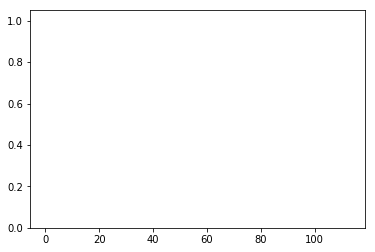

In [11]:
print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")
plt.bar(range(len(rList)), rList, color = "white", width = 0.00001)
plt.show()